# Checklist
* Dodać checkpointowanie
* Dodać macierz pomyłek do TB
* Zrobić zapis testu jednostkowego do pliku

#Python - instalacja modułów

In [1]:
%%shell
pip install hydra-core --upgrade --quiet
pip install unzip --quiet
pip install ipdb -Uqq
pip install pytorch-lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.8/775.8 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 KB 39.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 16.0 MB/s eta 0:00:00
    

#Python - import pakietów

In [82]:
# standardowe pakiety
import os
from os.path import join

import numpy as np

import scipy as sp
from scipy import array, newaxis

#from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import glob
import ipdb
from __future__ import print_function
from tqdm import tqdm

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torch.utils.data as data
import torchmetrics
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.profilers import PyTorchProfiler

# Hydra
import hydra
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

# tensorboard
#from sklearn.metrics import confusion_matrix
#import pandas as pd
#from torch.utils.tensorboard import SummaryWriter 
#import seaborn as sn


#Generacja plików konfiguracyjnych Hydra

Aby załadować checkpoint modelu należy w pliku classification.yaml podać jako parametr `model` jeden z następujących plików:
<br>`cls_model_own_pretrained` - własna implementacja,  
`cls_repo_model_pretrained` - modyfikacja repozytorium

In [3]:
os.environ['HYDRA_DIR'] = "/content/hydraConfs"

In [137]:
%%shell

mkdir ${HYDRA_DIR}

echo "name: classification
batch_size:               32
num_points:               512
cleaned_dataset:          False
dataset:                  'ModelNet40'
pretrained:               False
train_with_own:           False
model_pretrained:         ''
single_batch_overfit:     False" > ${HYDRA_DIR}/classification.yaml

echo "name: pl_trainer
default_root_dir:         '/content/saved/'
check_val_every_n_epoch:  1
num_sanity_val_steps:     5
accelerator:              'gpu'
devices:                  1
auto_select_gpus:         True 
max_epochs:               20
auto_scale_batch_size:    False 
amp_backend:              'native'
benchmark:                False 
overfit_batches:          0" > ${HYDRA_DIR}/pl_trainer.yaml

echo "name: optimizer
optimizer:                'Adam'
lr:                       0.01
betas:                    [0.9, 0.999]" > ${HYDRA_DIR}/optimizer.yaml

echo "name: scheduler
scheduler:                'StepLR'
step_size:                20
gamma:                    0.5" > ${HYDRA_DIR}/scheduler.yaml

mkdir: cannot create directory ‘/content/hydraConfs’: File exists


In [138]:
hydra_dir = os.environ.get('HYDRA_DIR')

confClass = OmegaConf.load(hydra_dir + "/classification.yaml")
confTrainer = OmegaConf.load(hydra_dir + "/pl_trainer.yaml")
confOptim = OmegaConf.load(hydra_dir + "/optimizer.yaml")
confSched = OmegaConf.load(hydra_dir + "/scheduler.yaml")

options = instantiate(confClass)
optionsTrainer = instantiate(confTrainer)
optionsOptim = instantiate(confOptim)
optionsSched = instantiate(confSched)

#Pobieranie danych

In [12]:
if not options.cleaned_dataset:
    ! wget -O modelnet40-normal_numpy.tar.zip https://box.skoltech.ru/index.php/s/dXgCWvAcYjgd7FC/download
    ! unzip modelnet40-normal_numpy.tar.zip > /dev/null
    ! rm modelnet40-normal_numpy.tar.zip > /dev/null
    ! tar -xvf modelnet40-normal_numpy.tar > /dev/null
    dataset_num_classes = 40
    dataset_root = '/content/modelnet40-normal_numpy/'
else:
    if options.dataset == 'ModelNet40':
        ! wget http://modelnet.cs.princeton.edu/ModelNet40.zip
        ! unzip -qq /content/ModelNet40.zip -d /content/
        dataset_num_classes = 40
        dataset_root = '/content/ModelNet40/'
    elif options.dataset == 'ModelNet10':
        ! wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
        ! unzip -qq /content/ModelNet10.zip -d /content/
        dataset_num_classes = 10
        dataset_root = '/content/ModelNet10/'
    else:
        raise ValueError("Wrong model name!")

--2023-01-04 14:07:14--  https://box.skoltech.ru/index.php/s/dXgCWvAcYjgd7FC/download
Resolving box.skoltech.ru (box.skoltech.ru)... 195.133.216.199
Connecting to box.skoltech.ru (box.skoltech.ru)|195.133.216.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1732629450 (1.6G) [application/zip]
Saving to: ‘modelnet40-normal_numpy.tar.zip’

modelnet40-normal_n 100%[===================>]   1.61G  28.4MB/s    in 2m 3s   

2023-01-04 14:09:18 (13.4 MB/s) - ‘modelnet40-normal_numpy.tar.zip’ saved [1732629450/1732629450]



#Obsługa danych

##Dataset (PyTorch)

In [69]:
class ModelNetDataset(data.Dataset):
    def __init__(self, root, randomize_pts=True, load_faces=False, split='train', num_classes=40, numpoints=5000, batch_size=32):
        self.root = root
        self.numpoints = numpoints
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.randomize_pts = randomize_pts
        self.load_faces = load_faces
        self.filelist = [f1 for f1 in glob.glob(self.root + '**/*.off', recursive=True)]
        self.trainlist = [f2 for f2 in self.filelist if "train" in f2]
        self.testlist = [f3 for f3 in self.filelist if "test" in f3]
        if split=='train': self.objlist = self.flist_reader(self.trainlist)
        if split=='test': self.objlist = self.flist_reader(self.testlist)

    def __getitem__(self, index):
        impath, target = self.objlist[index]

        #impath = "/content/ModelNet40/bowl/train/bowl_0005.off"
        #target = 6

        myF = open(impath, 'r')
        firstLine = myF.readline().strip()
        if 'OFF' != firstLine[0:3]:
            raise ValueError('Not a valid OFF header')
        if len(firstLine) > 3:
            n_verts, n_faces, n_edges = tuple([int(s) for s in firstLine[3:].split(' ')])
        else:
            n_verts, n_faces, n_edges = tuple([int(s) for s in myF.readline().strip().split(' ')])
        verts = np.array([[float(s) for s in myF.readline().strip().split(' ')] for i_vert in range(n_verts)])
        choice = np.random.choice(verts.shape[0], self.numpoints, replace=True)
        if self.randomize_pts:
          point_set = verts[choice, :]
        else:
          point_set = verts
        
        point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0) 
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
        point_set = point_set / dist  
        
        point_set = torch.from_numpy(point_set.astype(np.float32)).float()

        if self.load_faces:
            faces = np.array([[int(s) for s in myF.readline().strip().split(' ')][1:] for i_face in range(n_faces)])
            return point_set, target, faces
        else:
            return point_set, target

    def flist_reader(self, filelist):
        classes_dirs = glob.glob(self.root + "*/", recursive = False)
        classes_list = [i.split('/')[3] for i in classes_dirs]
        classes_nums = np.linspace(0,self.num_classes-1,self.num_classes)
        self.classes_dict = dict(zip(sorted(classes_list), classes_nums.astype(int)))
        self.nums_dict = dict(map(reversed, self.classes_dict.items()))
        objlist = []

        for line in filelist:
            label_start_index = line.strip().find(self.root) + len(self.root)
            label_end_index = line.strip()[label_start_index:].find('/')
            imlabel = line.strip()[label_start_index:label_start_index+label_end_index]
            imlabel = self.classes_dict[imlabel]
            impath = line
            objlist.append( (impath, imlabel) )
        return objlist

    def __len__(self):
      return len(self.objlist)

In [111]:
class ModelNetDatasetNP(data.Dataset):
    def __init__(self, root, randomize_pts=True, load_faces=False, split='train', num_classes=40, numpoints=5000, batch_size=32):
        self.root = root
        self.numpoints = numpoints
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.randomize_pts = randomize_pts
        self.load_faces = load_faces
        self.test_file = open(self.root + "modelnet40_test.txt", "r")
        self.train_file = open(self.root + "modelnet40_train.txt", "r")
        if split=='train': 
            self.objlistNoClass = self.train_file.read().replace('\n', ' ').split(" ")
        if split=='test': 
            self.objlistNoClass = self.test_file.read().replace('\n', ' ').split(" ")

        self.classlist = [item[:-5] for item in self.objlistNoClass]
        self.objlist = tuple(zip(self.objlistNoClass, self.classlist))[:-1]

        self.classes_file = open(self.root + "modelnet40_shape_names.txt", "r")
        self.classes_list = self.classes_file.read().replace('\n', ' ').split(" ")
        self.classes_nums = np.linspace(0,self.num_classes-1,self.num_classes)
        self.classes_dict = dict(zip(sorted(self.classes_list), self.classes_nums.astype(int)))
        self.nums_dict = dict(map(reversed, self.classes_dict.items()))

    def __getitem__(self, index):
        impath, target = self.objlist[index]
        #impath = "bowl_0005"
        #target = "bowl"
        try:
            array =  np.load(self.root + target + "/" + impath + ".npy")
        except FileNotFoundError:
            print("Znaleziono błąd")
            print(index)
        point_set = array[:, :3]
        if self.randomize_pts:
            choice = np.random.choice(point_set.shape[0], self.numpoints, replace=True)
            point_set = point_set[choice, :]
        
        point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0) 
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
        point_set = point_set / dist  
        
        point_set = torch.from_numpy(point_set.astype(np.float32)).float()
        target = self.classes_dict[target]
        return point_set, target

    def __len__(self):
        return len(self.objlist)

##x

In [43]:
test_file = open("/content/modelnet40-normal_numpy/modelnet40_test.txt", "r")
objlist = test_file.read().replace('\n', ' ').split(" ")
print(objlist)
asd = [item[:-5] for item in objlist]
print(asd)
objlist1 = tuple(zip(objlist, asd))
print(objlist1)

['airplane_0627', 'airplane_0628', 'airplane_0629', 'airplane_0630', 'airplane_0631', 'airplane_0632', 'airplane_0633', 'airplane_0634', 'airplane_0635', 'airplane_0636', 'airplane_0637', 'airplane_0638', 'airplane_0639', 'airplane_0640', 'airplane_0641', 'airplane_0642', 'airplane_0643', 'airplane_0644', 'airplane_0645', 'airplane_0646', 'airplane_0647', 'airplane_0648', 'airplane_0649', 'airplane_0650', 'airplane_0651', 'airplane_0652', 'airplane_0653', 'airplane_0654', 'airplane_0655', 'airplane_0656', 'airplane_0657', 'airplane_0658', 'airplane_0659', 'airplane_0660', 'airplane_0661', 'airplane_0662', 'airplane_0663', 'airplane_0664', 'airplane_0665', 'airplane_0666', 'airplane_0667', 'airplane_0668', 'airplane_0669', 'airplane_0670', 'airplane_0671', 'airplane_0672', 'airplane_0673', 'airplane_0674', 'airplane_0675', 'airplane_0676', 'airplane_0677', 'airplane_0678', 'airplane_0679', 'airplane_0680', 'airplane_0681', 'airplane_0682', 'airplane_0683', 'airplane_0684', 'airplane_068

In [ ]:
classes_file = open("/content/modelnet40-normal_numpy/modelnet40_shape_names.txt", "r")
classes_list = classes_file.read().replace('\n', ' ').split(" ")
classes_nums = np.linspace(0,40-1,40)
classes_dict = dict(zip(sorted(classes_list), classes_nums.astype(int)))
nums_dict = dict(map(reversed, classes_dict.items()))
print(classes_dict)
print(nums_dict)

{'airplane': 0, 'bathtub': 1, 'bed': 2, 'bench': 3, 'bookshelf': 4, 'bottle': 5, 'bowl': 6, 'car': 7, 'chair': 8, 'cone': 9, 'cup': 10, 'curtain': 11, 'desk': 12, 'door': 13, 'dresser': 14, 'flower_pot': 15, 'glass_box': 16, 'guitar': 17, 'keyboard': 18, 'lamp': 19, 'laptop': 20, 'mantel': 21, 'monitor': 22, 'night_stand': 23, 'person': 24, 'piano': 25, 'plant': 26, 'radio': 27, 'range_hood': 28, 'sink': 29, 'sofa': 30, 'stairs': 31, 'stool': 32, 'table': 33, 'tent': 34, 'toilet': 35, 'tv_stand': 36, 'vase': 37, 'wardrobe': 38, 'xbox': 39}
{0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33:

In [ ]:
array =  np.load("/content/modelnet40-normal_numpy/bookshelf/bookshelf_0002.npy")
print(array[1:10, :])

[[-5.845e-01 -7.969e-01 -1.301e-01 -5.765e-02 -9.977e-01 -3.608e-02]
 [-5.913e-01  7.930e-01 -1.224e-01 -9.727e-01  2.313e-01 -1.996e-02]
 [ 5.906e-01 -6.994e-01  1.302e-01  9.896e-01  1.022e-02  1.432e-01]
 [-1.867e-01  7.250e-04  1.338e-01 -6.977e-01 -3.171e-03  7.164e-01]
 [ 4.200e-01 -8.664e-02 -1.301e-01 -3.473e-02 -9.061e-01 -4.216e-01]
 [ 7.250e-04  7.828e-01  1.338e-01  0.000e+00 -6.386e-01  7.695e-01]
 [-2.623e-02 -7.431e-01  1.368e-01  5.000e-06  2.352e-02  9.997e-01]
 [-5.845e-01  2.448e-01 -1.374e-01 -1.745e-01  0.000e+00 -9.847e-01]
 [-5.895e-01 -3.410e-01  1.351e-01 -7.095e-01  2.800e-05  7.047e-01]]


##Datamodule (PyTorch Lightning)


In [131]:
class ModelNetDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        if options.cleaned_dataset:
            self.datasetClass = ModelNetDataset
        else:
            self.datasetClass = ModelNetDatasetNP

    def prepare_data(self):
        pass
        #funkcja celowo pozostawiona pusta - pobieranie danycn jest na początku notatnika, zaś obsługa danych w klasie ModelNetDataset
        
    def setup(self, stage = None):
        if stage == "fit" or stage is None:
            dataset = self.datasetClass(
                root=dataset_root, 
                num_classes=dataset_num_classes, 
                batch_size=options.batch_size, 
                split='train', 
                numpoints=options.num_points)
            traindataset_size = int(len(dataset) * 0.9)
            valid_set_size = len(dataset) - traindataset_size
            self.traindataset, self.valdataset = random_split(dataset, [traindataset_size, len(dataset) - traindataset_size])

        if stage == "test" or stage is None:
            self.testdataset = self.datasetClass(
                root=dataset_root, 
                num_classes=dataset_num_classes, 
                batch_size=options.batch_size, 
                split='test', 
                numpoints=options.num_points)
            
    def train_dataloader(self):
        return DataLoader(
            self.traindataset, 
            batch_size=options.batch_size, 
            num_workers=4, 
            shuffle=True)

    def val_dataloader(self):
        return DataLoader(
            self.valdataset, 
            batch_size=options.batch_size, 
            num_workers=4, 
            shuffle=False)

    def test_dataloader(self):
        return DataLoader(
            self.testdataset, 
            batch_size=options.batch_size, 
            num_workers=4, 
            shuffle=False)


##Wyświetlanie jednego obiektu

In [ ]:
def disp(vertices, target, faces, dataset, full):
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    
    V_np = np.asarray(vertices.cpu())
    if not full:
      ax.scatter(V_np[:, 0], V_np[:, 1], V_np[:, 2])
    else:
      ax.plot_trisurf(V_np[:, 0], V_np[:, 1], V_np[:, 2], triangles=faces);

    plt.axis('off')
    plt.show()
    print('Etykieta klasy: {}'.format(target))
    print(dataset.nums_dict[target])
    print('')
    
#test for all objects
'''
print(len(mdltest))

for n in range(len(mdltest)):
  xxx = mdltest[n]
  if xxx[0].shape[0] == 0:
    ipdb.set_trace(context=5)
'''

#mdltest = ModelNetDataset(root=dataset_root, randomize_pts = False, load_faces=True)
#mdltestR = ModelNetDataset(root=dataset_root, randomize_pts = True, load_faces=True)
mdltestNP = ModelNetDatasetNP(root="/content/modelnet40-normal_numpy/", randomize_pts = False, load_faces=True)

print("Ilość obiektów w zbiorze: {}".format(len(mdltestNP)))
ind = random.randint(0, len(mdltestNP))
#xxx = mdltest[ind]
#xxxR = mdltestR[ind]
xxxNP = mdltestNP[9842]


#disp(xxx[0], xxx[1], xxx[2], mdltest, full=False)
#disp(xxx[0], xxx[1], xxx[2], mdltest, full=True)

disp(xxxNP[0], xxxNP[1], _, mdltestNP, full=False)
#disp(xxxR[0], xxxR[1], xxxR[2], mdltestR, full=False)


#Model

## Model (PyTorch)

In [27]:
class SmallNet(nn.Module):
      def __init__(self, k=dataset_num_classes):
          super().__init__()
          self.conv1 =  torch.nn.Conv1d(3, 64, 1)
          self.bn1 =    nn.BatchNorm1d(64)
          self.relu =   nn.ReLU()
          self.fn =     nn.Linear(64, k)

      def forward(self, x):
          x = x.transpose(2, 1)
          #ipdb.set_trace(context=5)
          x = F.relu(self.bn1(self.conv1(x)))
          x = torch.max(x, 2, keepdim=False)[0]
          x = self.fn(x)
          return x

##Model - repo

In [64]:
class STN(nn.Module):
    def __init__(self, kd=True):
        if kd:  self.k=64; self.iden_arr=np.eye(self.k).flatten()
        else:   self.k=3;  self.iden_arr=np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]) 
        self.kd = kd
        super(STN, self).__init__()
        self.conv1 = torch.nn.Conv1d(self.k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.k*self.k)
        self.relu = nn.ReLU()

        for x in range(5): 
          string= "self.bn" + str(x+1) + "=nn.BatchNorm1d(" + str(64*2**(x)) + ")"
          exec(string)
        
    def forward(self, x):
        if not self.kd: x = x.transpose(2, 1) #TYLKO Z LIGHTNINGIEM
        batchsize = x.shape[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn5(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024) 
        x = F.relu(self.bn4(self.fc1(x))) 
        x = F.relu(self.bn3(self.fc2(x)))
        x = self.fc3(x)
        iden = torch.from_numpy(self.iden_arr.astype(np.float32)).view(1, self.k*self.k).repeat(batchsize, 1)
        if x.is_cuda:
            iden = iden.to(x.device)
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn = STN(kd=False)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.fstn = STN()

    def forward(self, x):
        n_pts = x.shape[2]
        trans = self.stn(x)
        #x = x.transpose(2, 1) #USUNĄĆ TYLKO Z LIGHTNINGIEM
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        trans_feat = self.fstn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans_feat)
        x = x.transpose(2,1)

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.to(trans.device)
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

class PointNetCls(nn.Module):
    def __init__(self, k=dataset_num_classes):
        super(PointNetCls, self).__init__()
        self.feat = PointNetfeat(global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat

##Model - własny

In [78]:
class STN(nn.Module):
    def __init__(self, kd=True):
        if kd:  self.k=64; self.iden_arr=np.eye(self.k).flatten()
        else:   self.k=3;  self.iden_arr=np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]) 
        self.kd = kd
        super().__init__()
        self.conv1 = nn.Conv1d(self.k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.k*self.k)
        self.relu = nn.ReLU()

        for x in range(5): 
          string= "self.bn" + str(x+1) + "=nn.BatchNorm1d(" + str(64*2**(x)) + ")"
          exec(string)
        
    def forward(self, x):
        if not self.kd: x = x.transpose(2, 1) #TYLKO Z LIGHTNINGIEM
        batchsize = x.shape[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn5(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024) 
        x = F.relu(self.bn4(self.fc1(x))) 
        x = F.relu(self.bn3(self.fc2(x)))
        x = self.fc3(x)
        iden = torch.from_numpy(self.iden_arr.astype(np.float32)).view(1, self.k*self.k).repeat(batchsize, 1)
        if x.is_cuda:
            iden = iden.to(x.device)
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class MLP_NxM(nn.Module):
  def __init__(self,N=1,M=1,end=False):
        super().__init__()
        self.N = N
        self.M = M
        self.end = end;
        self.conv1 = nn.Conv1d(N, M, 1)
        self.bn1 = nn.BatchNorm1d(M)

  def forward(self, x):
        if self.end:
          x = x.transpose(0, 1)
          x = self.conv1(x)
        else:
          x = x.transpose(2,1)
          x = F.relu(self.bn1(self.conv1(x)))
        return x 

class TopLevelEntity(nn.Module):
  def __init__(self, N=1, M=1, k=dataset_num_classes):
        super().__init__()
        self.MLP_3x64=MLP_NxM(N=3,M=64)
        self.STN3d=STN(kd=False)
        self.MLP_64x1024=MLP_NxM(N=64,M=1024)
        self.STN64d=STN(kd=True)
        self.MLP_1024x40=MLP_NxM(N=1024,M=k,end=True)

  def forward(self, x):
        trans = self.STN3d(x)
        x = torch.bmm(x,trans)
        x = self.MLP_3x64(x)
        trans = self.STN64d(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x,trans)
        x = self.MLP_64x1024(x)
        x, _ = torch.max(x,2)
        x = self.MLP_1024x40(x)
        x = x.transpose(0, 1)
        x = F.log_softmax(x,dim=1)
        return x

## Module (PyTorch Lightning)

In [134]:
class GenericClassifier(pl.LightningModule):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.batch_size = options.batch_size
        self.lr = optionsOptim.lr
        self.num_classes = dataset_num_classes
        self.current_epoch_training_loss = torch.tensor(0.0)
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, x, y): 
        #return F.cross_entropy(x, y)
        loss = F.nll_loss(x, y)
        if not options.train_with_own:
            loss += feature_transform_regularizer(self.trans_feat) * 0.001
        return loss
        
    def common_step(self, batch, batch_idx):
        x, y = batch
        if options.train_with_own:
            outputs = self(x)
        else:
            outputs, _, self.trans_feat = self(x) # tutaj podłogi dlatego że PointNetCls zwraca [wyjście, trans, trans_feat]
        loss = self.compute_loss(outputs,y)
        return loss, outputs, y

    def common_test_valid_step(self, batch, batch_idx):
        loss, outputs, y = self.common_step(batch, batch_idx)
        preds = torch.argmax(outputs, dim=1)
        acc = torchmetrics.functional.accuracy(preds, y, task="multiclass", num_classes = self.num_classes)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _, _ = self.common_step(batch, batch_idx)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True) # w tym przykładzie self.log jest explicite, niemniej domyślnie jest on włączony, szczegóły: https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html#id3
        return {'loss':loss}

    def training_epoch_end(self, outs):
        self.current_epoch_training_loss = torch.stack([o["loss"] for o in outs]).mean()
        
    def validation_step(self, batch, batch_idx):
        loss, acc = self.common_test_valid_step(batch, batch_idx)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)        
        return {'val_loss':loss, 'val_acc': acc}

    def validation_epoch_end(self, outs):
        avg_loss = torch.stack([o["val_loss"] for o in outs]).mean()
        self.logger.experiment.add_scalars('train and vall losses', {'train': self.current_epoch_training_loss.item() , 'val': avg_loss.item()}, self.current_epoch)

    def test_step(self, batch, batch_idx):
        loss, acc = self.common_test_valid_step(batch, batch_idx)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'test_loss':loss, 'test_acc': acc}

    def configure_optimizers(self):
        f1 = getattr(optim, confOptim.optimizer)
        f2 = getattr(optim.lr_scheduler, confSched.scheduler)
        optimizer = f1(self.parameters(), confOptim.lr, confOptim.betas)
        lr_scheduler = f2(optimizer, confSched.step_size, confSched.gamma)
        #string = "optimizer = optim." + confOptim.optimizer + "(self.parameters(), confOptim.lr, confOptim.betas)"
        #exec(string, locals())
        #string = "lr_scheduler = optim.lr_scheduler." + confSched.scheduler + "(optimizer, confSched.step_size, confSched.gamma)" 
        #exec(string, locals())
        
        return [optimizer], [lr_scheduler] 


#Trenowanie

##Test jednostkowy z profilowaniem

In [87]:
PointNetModel = PointNetCls(k = dataset_num_classes)

PointNetModelOwn = TopLevelEntity(k = dataset_num_classes)

model = GenericClassifier(PointNetModelOwn)

dm = ModelNetDataModule()
dm.setup()

trainer = pl.Trainer(
    default_root_dir =          optionsTrainer.default_root_dir,
    check_val_every_n_epoch =   optionsTrainer.check_val_every_n_epoch, 
    num_sanity_val_steps =      optionsTrainer.num_sanity_val_steps, 
    accelerator =               optionsTrainer.accelerator,
    devices =                   optionsTrainer.devices,
    auto_select_gpus =          optionsTrainer.auto_select_gpus, 
    max_epochs =                optionsTrainer.max_epochs, 
    auto_scale_batch_size =     optionsTrainer.auto_scale_batch_size, 
    amp_backend =               optionsTrainer.amp_backend, 
    benchmark =                 optionsTrainer.benchmark, 
    overfit_batches =           optionsTrainer.overfit_batches,
    fast_dev_run =              True, 
    profiler =                  "simple"
    )

trainer.fit(model=model, datamodule=dm)

INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type           | Params
-----------------------------------------
0 | model | TopLevelEntity | 2.8 M 
-----------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.082    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##Szukanie parametrów

INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO:pytorch_lightning.utilities.rank_zero:Batch size 2 succeeded, trying batch size 4
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO:pytorch_lightning.utilities.rank_zero:Batch size 4 succeeded, trying batch size 8
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO:pytorch_lightning.utilities.rank_zero:Batch size 8 succeeded,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/saved/.lr_find_e894ed78-65fe-4f33-9d6e-0da8cbebc945.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/saved/.lr_find_e894ed78-65fe-4f33-9d6e-0da8cbebc945.ckpt


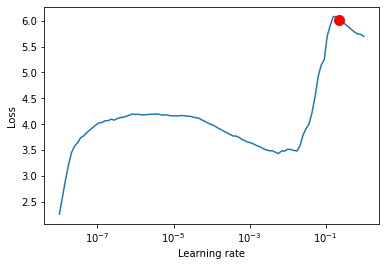

In [122]:
PointNetModel = PointNetCls(k = dataset_num_classes)

PointNetModelOwn = TopLevelEntity(k = dataset_num_classes)

model = GenericClassifier(PointNetModelOwn)

dm = ModelNetDataModule()
dm.setup()

trainer = pl.Trainer(
    default_root_dir =          optionsTrainer.default_root_dir,
    check_val_every_n_epoch =   optionsTrainer.check_val_every_n_epoch, 
    num_sanity_val_steps =      optionsTrainer.num_sanity_val_steps, 
    accelerator =               optionsTrainer.accelerator,
    devices =                   optionsTrainer.devices,
    auto_select_gpus =          optionsTrainer.auto_select_gpus, 
    max_epochs =                optionsTrainer.max_epochs, 
    auto_scale_batch_size =     optionsTrainer.auto_scale_batch_size, 
    amp_backend =               optionsTrainer.amp_backend, 
    benchmark =                 optionsTrainer.benchmark, 
    overfit_batches =           optionsTrainer.overfit_batches)
    
tuner = pl.tuner.tuning.Tuner(trainer)
max_batch_size = tuner.scale_batch_size(model, datamodule=dm)

lr_finder = tuner.lr_find(model, datamodule=dm)
found_lr = lr_finder.suggestion()

fig = lr_finder.plot(suggest=True)
fig.show()

##Trening

In [139]:
if options.train_with_own:
    PointNetModel = TopLevelEntity(k = dataset_num_classes)
else:
    PointNetModel = PointNetCls(k = dataset_num_classes)

model = GenericClassifier(PointNetModel)

dm = ModelNetDataModule()
dm.setup()

tb_logger = pl.loggers.TensorBoardLogger('/content/lightning_logs/', name='pointnet_logs')

trainer = pl.Trainer(
    default_root_dir =          optionsTrainer.default_root_dir,
    check_val_every_n_epoch =   optionsTrainer.check_val_every_n_epoch, 
    num_sanity_val_steps =      optionsTrainer.num_sanity_val_steps, 
    accelerator =               optionsTrainer.accelerator,
    devices =                   optionsTrainer.devices,
    auto_select_gpus =          optionsTrainer.auto_select_gpus, 
    max_epochs =                optionsTrainer.max_epochs, 
    auto_scale_batch_size =     optionsTrainer.auto_scale_batch_size, 
    amp_backend =               optionsTrainer.amp_backend, 
    benchmark =                 optionsTrainer.benchmark, 
    overfit_batches =           optionsTrainer.overfit_batches,
    logger =                    tb_logger
    )

if options.pretrained:
    modelPretrained = model.load_from_checkpoint("/content/saved/...")
    modelPretrained.eval()
    #y_hat = modelPretrained(datamodule=dm)
    results = trainer.test(model=modelPretrained, datamodule=dm, verbose=True)

else:
    trainer.fit(
        model=model, 
        datamodule=dm)
    
    

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | PointNetCls | 3.5 M 
--------------------------------------
3.5 M     Trainable para

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


#Testowanie

In [140]:
trainer.test(datamodule=dm)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/pointnet_logs/version_10/checkpoints/epoch=19-step=5540.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/lightning_logs/pointnet_logs/version_10/checkpoints/epoch=19-step=5540.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8152350187301636
     test_loss_epoch        0.6424053311347961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.6424053311347961, 'test_acc_epoch': 0.8152350187301636}]

In [114]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/lightning_logs/pointnet_logs/